In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.regularizers import L2, L1L2, L1
from keras import regularizers
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import tensorflow as tf
from keras.regularizers import L1L2
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

In [72]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [73]:
df_train.head()

,tweets,labels
0,tempat yang nyaman untuk berkumpul dengan tema...,positive
1,"memang banyak bacot sih , omongan doang gede b...",negative
2,"buat yang berkunjung ke bandung , yang ingin m...",positive
3,restoran menyajikan makanan khas sunda yang en...,positive
4,"kalau travelling ke bandung , wajib makan bata...",positive


In [74]:
df_train.tail()

,tweets,labels
9895,warung nasi ampera memiliki konsep rumah makan...,positive
9896,"mbak della sangat baik dan ramah , makanna nya...",positive
9897,suasana nya sangat romantis jika makan malam d...,positive
9898,masyarakat tidak kecewa jika dipimpin oleh jok...,positive
9899,mau itu pak ridwan kamil atau pak dedi mulyadi...,positive


In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  9900 non-null   object
 1   labels  9900 non-null   object
dtypes: object(2)
memory usage: 154.8+ KB


In [76]:
df_train.isna().sum()

tweets    0
labels    0
dtype: int64

In [77]:
df_train.duplicated().sum()

60

In [78]:
df_train = df_train.drop_duplicates()

In [79]:
df_train.duplicated().sum()

0

In [80]:
# displays the number of columns and rows of the dataframe

shape = df_train.shape
print("Number of columns and number of rows (columns, rows) : \n {}".format(shape))

Number of columns and number of rows (columns, rows) : 
 (9840, 2)


In [81]:
df_train.labels.value_counts()

positive    5760
negative    3063
neutral     1017
Name: labels, dtype: int64

Terlihat bahwa data imbalance berdasarkan jumlah label. Pada tahap preprocessing data sebelum Modeling harus dilakukan balancing

In [82]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [83]:
df_train['tweets'] = df_train['tweets'].apply(cleansing)
df_test['tweets'] = df_test['tweets'].apply(cleansing)

## Feature Engineering

In [84]:
df_train['total_word'] = df_train['tweets'].apply(lambda x: len(x.split()))
df_train['total_char'] = df_train['tweets'].apply(len)
df_train.head()

,tweets,labels,total_word,total_char
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,195
1,memang banyak bacot sih omongan doang gede boc...,negative,33,199
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,243
3,restoran menyajikan makanan khas sunda yang en...,positive,33,237
4,kalau travelling ke bandung wajib makan batago...,positive,39,228


## Descriptive Statistics

### Mean, Median, Mode

In [85]:
total_word_mean = df_train['total_word'].mean()
total_char_mean = df_train['total_char'].mean()

total_word_median = df_train['total_word'].median()
total_char_median = df_train['total_char'].median()

total_word_mode = df_train['total_word'].mode()
total_char_mode = df_train['total_char'].mode()


print(f"Mean dari total kata : {total_word_mean} \nMean dari total karakter : {total_char_mean}")
print("\n")
print(f"Median dari total kata : {total_word_median} \nMedian dari total karakter : {total_char_median}")
print("\n")
print(f"Mode dari total kata : {total_word_mode} \nMode dari total karakter : {total_char_mode}")

Mean dari total kata : 29.07540650406504 
Mean dari total karakter : 180.57815040650408


Median dari total kata : 25.0 
Median dari total karakter : 153.0


Mode dari total kata : 0    8
Name: total_word, dtype: int64 
Mode dari total karakter : 0    62
Name: total_char, dtype: int64


### Range

Digunakan untuk mencari perbedaan antara nilai terbesar dengan nilai terkecil pada data.

In [86]:
range_total_word = df_train.total_word.max() - df_train.total_word.min() 
range_total_word

84

### IQR dan Mencari Outlier

In [87]:
# cari nilai minimum
p0 = df_train.total_word.min()

# cari nilai maksimum
p100 = df_train.total_word.max()

# cari Quartile 1
q1 = df_train.total_word.quantile(0.25)

#cari Quartile 2
q2 = df_train.total_word.quantile(0.5)

#cari Quartile 3
q3 = df_train.total_word.quantile(0.75)

# cari IQR
iqr = q3 - q1

# cari batas bawah
lower_limit = q1-1.5*iqr

# cari batas atas
upper_limit = q3+1.5*iqr

# menentukan batas outlier dari data yang kita punya :
# Cek apakah ada outlier dari batas bawah
print("Batas Bawah 'total_word' :", lower_limit)
print("Nilai minimum =", p0)
if lower_limit < p0 :
  print("Tidak ada outlier dari sisi batas bawah")
else :
  print("Ada outlier dari sisi batas bawah")

# Cek apa ada outlier dari batas atas
print("="*10)
print("Batas Atas 'total_word' :", upper_limit)
print("Nilai maksimum =", p100)
if upper_limit >  p100 :
  print("Tidak ada outlier dari sisi batas atas")
else :
  print("Ada outlier dari sisi batas atas")

Batas Bawah 'total_word' : -29.5
Nilai minimum = 1
Tidak ada outlier dari sisi batas bawah
Batas Atas 'total_word' : 86.5
Nilai maksimum = 85
Tidak ada outlier dari sisi batas atas


### Variance

Digunakan untuk mengukur seberapa menyebar data yang ada dari mean-nya. Jika nilai variance dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka nilai dari suatu variabel/kolom tersebut menjauhi mean.

In [88]:
print(f"Variance dari total kata : {df_train['total_word'].var()}")
print(f"Variance dari total karakter : {df_train['total_char'].var()}")

Variance dari total kata : 342.0182994586848
Variance dari total karakter : 13308.884023004774


### Standard Deviation

Digunakan untuk mengukur penyebaran observasi dalam kumpulan data relatif terhadap rata-ratanya. Jika nilai standard deviation dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka data dari suatu variabel/kolom tersebut menjauhi mean.


In [89]:
print(f"Standard Deviasi dari total kata : {df_train['total_word'].std()}")
print(f"Standard Deviasi dari total karakter : {df_train['total_char'].std()}")

Standard Deviasi dari total kata : 18.493736762987755
Standard Deviasi dari total karakter : 115.36413664135303


### Skewness
Merupakan suatu cara untuk mengukur ketidaksimetrisan suatu distribusi nilai.

*   Apabila nilai skewness = 0, maka menunjukkan data berdistribusi normal.
*   Apabila nilai skewness < 0, maka menunjukkan skewness bernilai negatif.
*   Apabila nilai skewness > 0, maka menunjukkan skewness bernilai positif.

In [90]:
print(f"Skewness dari total kata : {df_train['total_word'].skew()}")
print(f"Skewness dari total karakter : {df_train['total_char'].skew()}")

Skewness dari total kata : 0.5374248059635697
Skewness dari total karakter : 0.5721531476320324


Dapat terlihat bahwa total word dan total karakter dari data memiliki skewness positif (Cenderung jatuh ke kanan)

### Kurtosis
Merupakan suatu cara untuk menunjukan derajat keruncingan, semakin besar nilai kurtosis maka kurva semakin runcing.

Kurtosis memiliki kondisi sebagai berikut:

*   Kurtosis yang memiliki nilai 3 berarti memiliki Distribusi Normal
*   Jika nilai Kurtosis kurang dari 3, dikatakan bersifat playkurtik, yang berarti cenderung menghasilkan lebih sedikit nilai outlier.
*   Jika nilai kurtosis lebih besar dari 3, dikatakan leptokurtik, yang berarti cenderung menghasilkan lebih besar nilai outlier.

In [91]:
print(f"Kurtosis dari total kata : {df_train['total_word'].kurtosis()}")
print(f"Kurtosis dari total karakter : {df_train['total_char'].kurtosis()}")

Kurtosis dari total kata : -0.8059908526434167
Kurtosis dari total karakter : -0.7441626308973057


## Visualization

Selain dengan pendekatan Descriptive Statistic, untuk mengetahui insight melalui Univariate Analysis bisa menggunakan visualisasi. 

Berikut contoh visualisasi Pie Chart untuk melihat persebaran total sentimen per kelasnya.

Berdasarkan gambar di bawah terlihat sentimen terbanyak ada di sentimen positif, selanjutnya sentimen negatif, dan yang terakhir sentimen netral. 

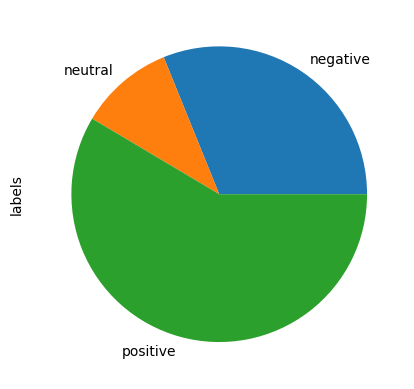

In [92]:
df_train.groupby('labels').labels.count().plot(kind='pie')
plt.savefig("pie_labels.png", bbox_inches = 'tight', dpi=300)

<AxesSubplot:xlabel='labels'>

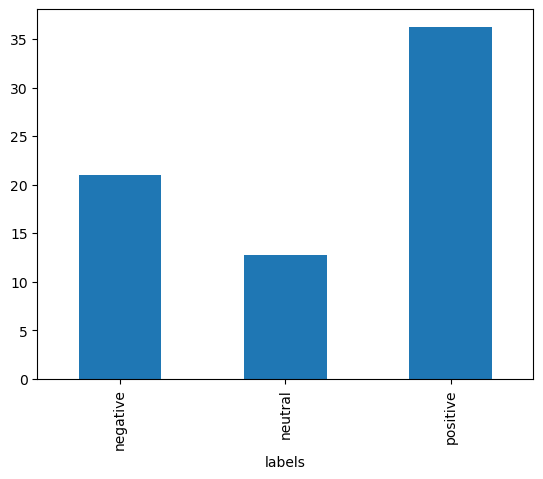

In [93]:
df_train.groupby('labels').total_word.mean().plot(kind='bar')

<AxesSubplot:xlabel='labels'>

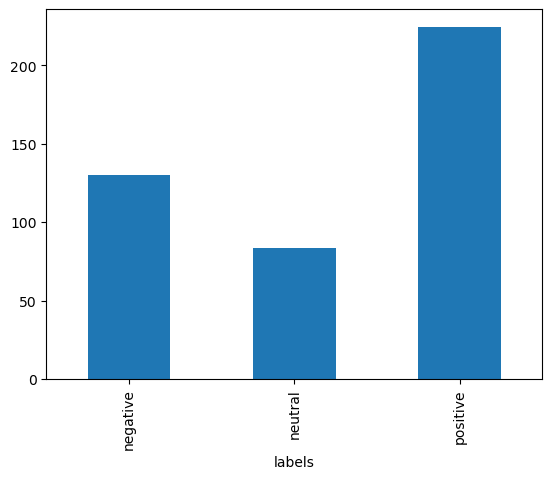

In [94]:
df_train.groupby('labels').total_char.mean().plot(kind='bar')

## Histogram

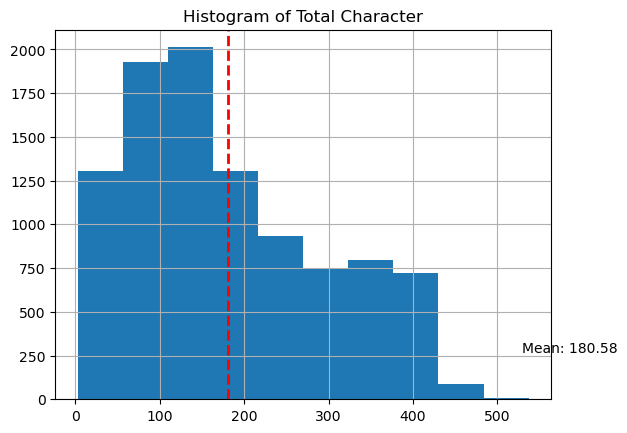

<Figure size 640x480 with 0 Axes>

In [95]:
df_train.total_char.hist()
plt.title("Histogram of Total Character")
plt.axvline(total_char_mean, color='r', linestyle='dashed', linewidth=2)
plt.text(x = df_train.total_char.max()-8, y = df_train.total_char.max()*0.5, s = 'Mean: {:.2f}'.format(total_char_mean), size = 10)
plt.show()
plt.savefig("hist_total_char.png", bbox_inches = 'tight', dpi=300)

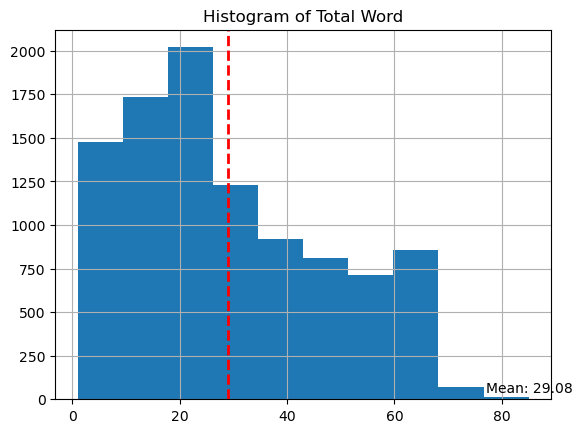

<Figure size 640x480 with 0 Axes>

In [96]:
df_train.total_word.hist()
plt.title("Histogram of Total Word")
plt.axvline(total_word_mean, color='r', linestyle='dashed', linewidth=2)
plt.text(x = df_train.total_word.max()-8, y = df_train.total_word.max()*0.5, s = 'Mean: {:.2f}'.format(total_word_mean), size = 10)
plt.show()
plt.savefig("hist_total_word.png", bbox_inches = 'tight', dpi=300)

### Histogram & Filter Sentiment

Kita bisa memfilter data berdasarkan sentimen setelah itu memvisualisasikannya dalam bentuk Histogram.


<AxesSubplot:>

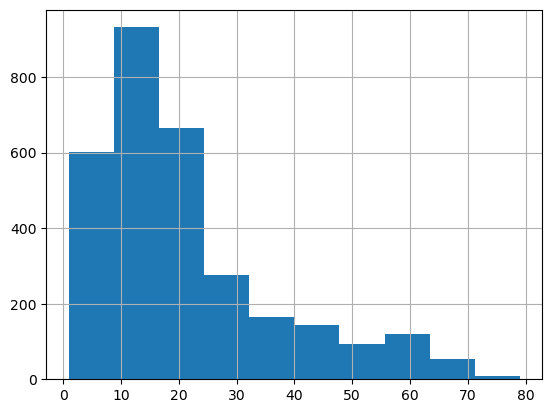

In [97]:
# misal visualisasi hanya berdasarkan sentimen negatif 
df_negative = df_train.loc[df_train['labels'] == 'negative']
df_negative['total_word'].hist()

<AxesSubplot:>

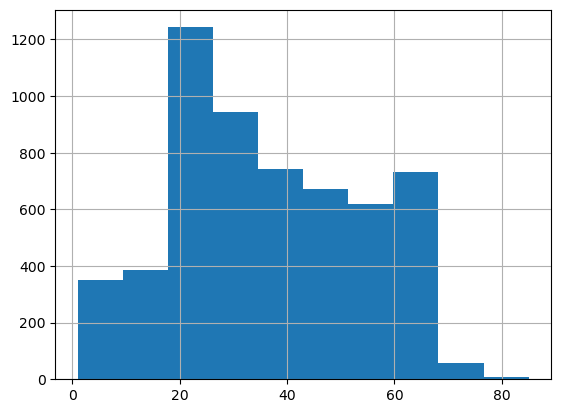

In [98]:
# misal visualisasi hanya berdasarkan sentimen positive
df_positive = df_train.loc[df_train['labels'] == 'positive']
df_positive['total_word'].hist()

<AxesSubplot:>

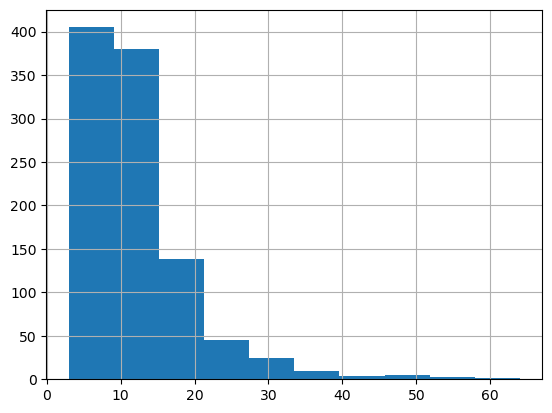

In [99]:
# misal visualisasi hanya berdasarkan sentimen neutral
df_neutral = df_train.loc[df_train['labels'] == 'neutral']
df_neutral['total_word'].hist()

## Wordcloud

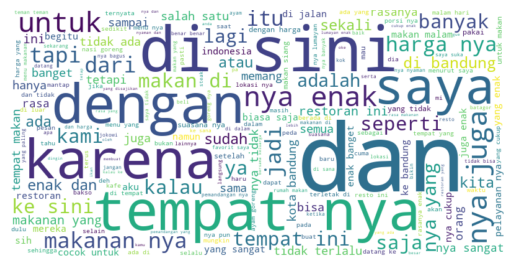

<Figure size 640x480 with 0 Axes>

In [100]:
# merge all text from dataframe (df)
text = ' '.join(df_train['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig("wordcloud.png", bbox_inches = 'tight', dpi=300)

## Wordcloud (Negative Labels)

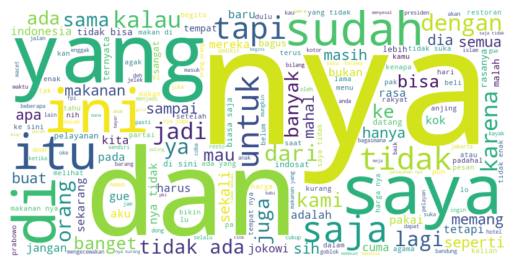

In [101]:
# merge all text from dataframe (df)
df_negative = df_train.loc[df_train['labels'] == 'negative']

text = ' '.join(df_negative['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [102]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_negative['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 2078), ('tidak', 1732), ('yang', 1531), ('dan', 1129), ('di', 1063), ('saya', 967), ('ini', 694), ('saja', 593), ('dengan', 575), ('itu', 550)]


## Wordcloud (Positive labels)

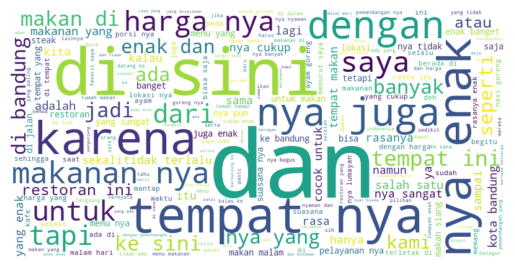

In [103]:
# merge all text from dataframe (df)
df_positive = df_train.loc[df_train['labels'] == 'positive']

text = ' '.join(df_positive['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [104]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_positive['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 9866), ('yang', 6615), ('dan', 5807), ('di', 5582), ('enak', 3142), ('dengan', 2897), ('tempat', 2874), ('makanan', 2857), ('saya', 2805), ('untuk', 2454)]


## Wordcloud (Neutral labels)

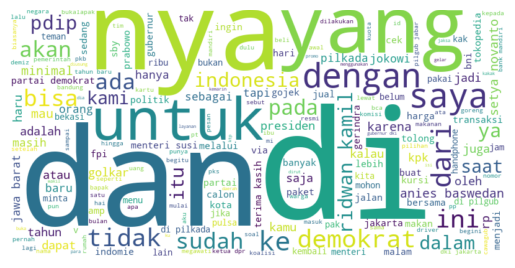

In [105]:
# merge all text from dataframe (df)
df_neutral = df_train.loc[df_train['labels'] == 'neutral']

text = ' '.join(df_neutral['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [106]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_neutral['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('di', 305), ('dan', 194), ('yang', 186), ('nya', 184), ('untuk', 135), ('dengan', 121), ('saya', 119), ('demokrat', 90), ('ke', 81), ('tidak', 79)]


## Counter untuk Mencari Bag of Words dari tiap Label

In [107]:
from collections import Counter

def get_word_frequency(label):
    words = []
    for text in df_train[df_train['labels'] == label]['tweets']:
        words += text.split()
    word_freq = Counter(words)
    return word_freq

pos_word_freq = get_word_frequency('positive')
neg_word_freq = get_word_frequency('negative')
ntrl_word_freq = get_word_frequency('neutral')

### Kata yang paling sering muncul pada label "positive"

In [108]:
pos_word_freq.most_common(10)

[('nya', 9866),
 ('yang', 6615),
 ('dan', 5807),
 ('di', 5582),
 ('enak', 3142),
 ('dengan', 2897),
 ('tempat', 2874),
 ('makanan', 2857),
 ('saya', 2805),
 ('untuk', 2454)]

### Kata yang paling sering muncul pada label "negative"

In [109]:
neg_word_freq.most_common(10)

[('nya', 2078),
 ('tidak', 1732),
 ('yang', 1531),
 ('dan', 1129),
 ('di', 1063),
 ('saya', 967),
 ('ini', 694),
 ('saja', 593),
 ('dengan', 575),
 ('itu', 550)]

### Kata yang paling sering muncul pada label "neutral"

In [110]:
ntrl_word_freq.most_common(10)

[('di', 305),
 ('dan', 194),
 ('yang', 186),
 ('nya', 184),
 ('untuk', 135),
 ('dengan', 121),
 ('saya', 119),
 ('demokrat', 90),
 ('ke', 81),
 ('tidak', 79)]

# Bivariate Analysis

In [111]:
df_train.corr()

,total_word,total_char
total_word,1.00000,0.99343
total_char,0.99343,1.00000


Korelasi antara total kata dengan total karakter dari masing-masing data sangat tinggi. Seperti kita ketahui, kata berasal dari kumpulan karakter. Mari kita buktikan dengan scatter plot

### Scatter Plot

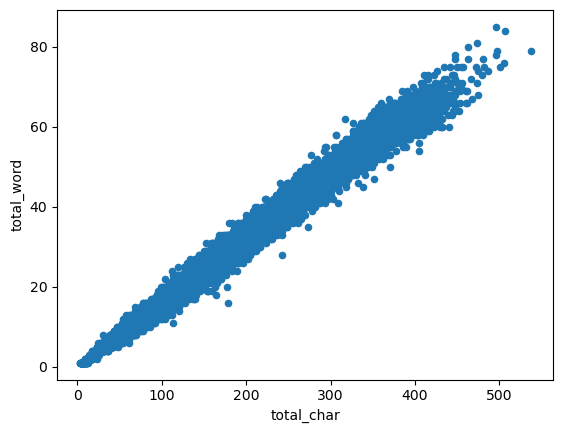

In [112]:
df_train.plot(x="total_char", y="total_word", kind='scatter')
plt.savefig("scatter_plot.png", bbox_inches = 'tight', dpi=300)

## Heatmap

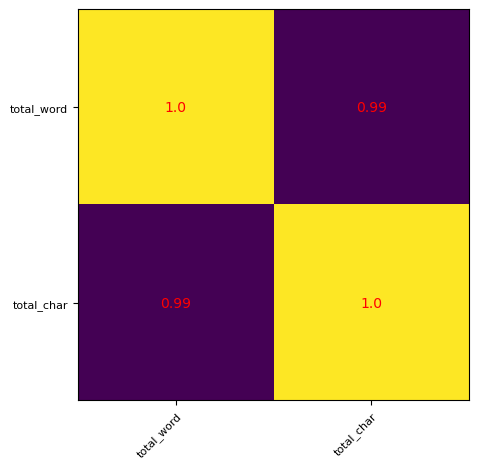

In [113]:
# get correlation matrix
corr = df_train.corr()
fig, ax = plt.subplots()
# create heatmap
im = ax.imshow(corr.values)
# set labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, fontsize=8)
ax.set_yticklabels(corr.columns, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2), ha="center", va="center", color="red", fontsize=10) # decrease font size of text annotations
plt.tight_layout() # adjust subplots to fit the figure size
plt.savefig("heatmap.png", bbox_inches = 'tight', dpi=300)
plt.show()

# **Modeling**

#### Sebelum tahap modeling ada beberapa proses, yaitu:
* Preprocessing Data (Cleansing data, cek outlier, splitting data, mengubah data teks menjadi numerikal)
* Balancing data (karena diketahui saat EDA bahwa pada data train terdapat imbalance label)

In [114]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [115]:
df_train['clean_tweets'] = df_train['tweets'].apply(cleansing)
df_test['clean_tweets'] = df_test['tweets'].apply(cleansing)

## Feature Engineering

In [116]:
df_train['word_tokens'] = df_train['clean_tweets'].apply(tokenisasi)
df_test['word_tokens'] = df_test['clean_tweets'].apply(tokenisasi)

In [117]:
df_train[['clean_tweets']][0:10]

,clean_tweets
0,tempat yang nyaman untuk berkumpul dengan tema...
1,memang banyak bacot sih omongan doang gede boc...
2,buat yang berkunjung ke bandung yang ingin men...
3,restoran menyajikan makanan khas sunda yang en...
4,kalau travelling ke bandung wajib makan batago...
5,mengurus kampung menata kota demiz demul ahli nya
6,menyajikan aneka macam ikan bakar disajikan de...
7,terletak di jalan cipaganti bandung di seberan...
8,jokowi adalah satu satunya presiden yang tidak...
9,alhamdulillah


## One Hot Encoding

In [118]:
le = LabelEncoder()

df_train['label_encode'] = le.fit_transform(df_train['labels'])
df_test['label_encode'] = le.transform(df_test['labels'])

display(df_train.head())

print(df_train.dtypes)

,tweets,labels,total_word,total_char,clean_tweets,word_tokens,label_encode
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,195,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2
1,memang banyak bacot sih omongan doang gede boc...,negative,33,199,memang banyak bacot sih omongan doang gede boc...,"[memang, banyak, bacot, sih, omongan, doang, g...",0
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,243,buat yang berkunjung ke bandung yang ingin men...,"[buat, yang, berkunjung, ke, bandung, yang, in...",2
3,restoran menyajikan makanan khas sunda yang en...,positive,33,237,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2
4,kalau travelling ke bandung wajib makan batago...,positive,39,228,kalau travelling ke bandung wajib makan batago...,"[kalau, travelling, ke, bandung, wajib, makan,...",2


tweets          object
labels          object
total_word       int64
total_char       int64
clean_tweets    object
word_tokens     object
label_encode     int32
dtype: object


In [119]:
df_train.isna().sum()

tweets          0
labels          0
total_word      0
total_char      0
clean_tweets    0
word_tokens     0
label_encode    0
dtype: int64

In [120]:
# Menggabungkan setiap elemen dalam kolom 'word_tokens' menjadi satu string
df_train['string_tokens'] = df_train['word_tokens'].apply(' '.join)

In [121]:
df_train

,tweets,labels,total_word,total_char,clean_tweets,word_tokens,label_encode,string_tokens
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,195,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2,tempat yang nyaman untuk berkumpul dengan tema...
1,memang banyak bacot sih omongan doang gede boc...,negative,33,199,memang banyak bacot sih omongan doang gede boc...,"[memang, banyak, bacot, sih, omongan, doang, g...",0,memang banyak bacot sih omongan doang gede boc...
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,243,buat yang berkunjung ke bandung yang ingin men...,"[buat, yang, berkunjung, ke, bandung, yang, in...",2,buat yang berkunjung ke bandung yang ingin men...
3,restoran menyajikan makanan khas sunda yang en...,positive,33,237,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2,restoran menyajikan makanan khas sunda yang en...
4,kalau travelling ke bandung wajib makan batago...,positive,39,228,kalau travelling ke bandung wajib makan batago...,"[kalau, travelling, ke, bandung, wajib, makan,...",2,kalau travelling ke bandung wajib makan batago...
...,...,...,...,...,...,...,...,...
9894,tiap kegaduhan melanda presiden sowan ke prabo...,negative,18,114,tiap kegaduhan melanda presiden sowan ke prabo...,"[tiap, kegaduhan, melanda, presiden, sowan, ke...",0,tiap kegaduhan melanda presiden sowan ke prabo...
9895,warung nasi ampera memiliki konsep rumah makan...,positive,45,294,warung nasi ampera memiliki konsep rumah makan...,"[warung, nasi, ampera, memiliki, konsep, rumah...",2,warung nasi ampera memiliki konsep rumah makan...
9896,mbak della sangat baik dan ramah makanna nya j...,positive,43,260,mbak della sangat baik dan ramah makanna nya j...,"[mbak, della, sangat, baik, dan, ramah, makann...",2,mbak della sangat baik dan ramah makanna nya j...
9897,suasana nya sangat romantis jika makan malam d...,positive,47,272,suasana nya sangat romantis jika makan malam d...,"[suasana, nya, sangat, romantis, jika, makan, ...",2,suasana nya sangat romantis jika makan malam d...


## Cek kata-kata dalam data frame yang tergolong ke dalam Outlier

[('nya', 12128), ('yang', 8332), ('dan', 7130), ('di', 6950), ('tidak', 3908), ('saya', 3891), ('dengan', 3593), ('enak', 3373), ('makanan', 3213), ('ini', 3192)]


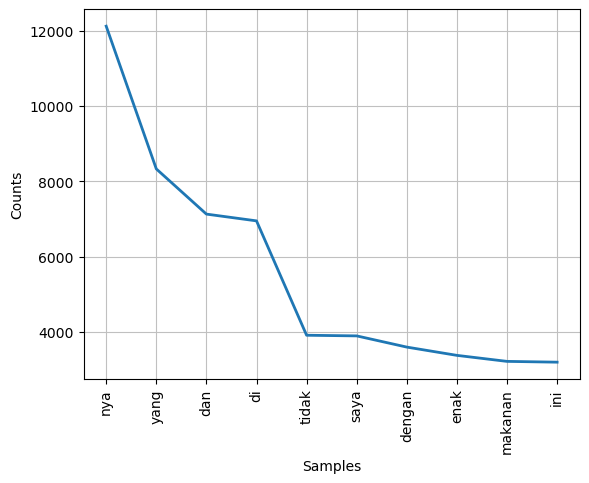

<Figure size 640x480 with 0 Axes>

In [122]:
# determine the word from df['tweet_without_stopwords'] that occurs frequently
text = ' '.join(df_train['string_tokens'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))
freq_kata.plot(10, cumulative=False)
plt.show()
plt.savefig("line_bagwords.png", bbox_inches = 'tight', dpi=300)

In [123]:
# get the frequency distribution of words
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))

# calculate the interquartile range (IQR) of word frequency
q1, q3 = np.percentile(list(freq_kata.values()), [1, 99])
iqr = q3 - q1

# calculate the upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# get the words that are outliers
outliers = [word for word, freq in freq_kata.items() if freq > upper_bound or freq < lower_bound]
print(outliers)

['tempat', 'yang', 'nyaman', 'untuk', 'dengan', 'ada', 'kalau', 'malam', 'cukup', 'enak', 'di', 'jalan', 'harga', 'banyak', 'ke', 'rasanya', 'itu', 'seperti', 'buat', 'bandung', 'tidak', 'nya', 'dan', 'makan', 'restoran', 'ini', 'menu', 'sangat', 'makanan', 'rasa', 'saya', 'tapi', 'banget', 'nasi', 'ayam', 'goreng', 'juga', 'adalah', 'bisa', 'pelayanan', 'saja', 'dari', 'suasana', 'pemandangan', 'lebih', 'bagus', 'sini', 'sudah', 'kami', 'karena', 'kita', 'suka', 'orang', 'sekali', 'jadi', 'sama']


In [124]:
# define a function to remove words from DataFrame
def remove_outliers(row):
    words = row['string_tokens'].split()
    words = [word for word in words if word not in outliers]
    return ' '.join(words)

# apply the function to the DataFrame
df_train['clean_string'] = df_train.apply(remove_outliers, axis=1)

In [125]:
df_train

,tweets,labels,total_word,total_char,clean_tweets,word_tokens,label_encode,string_tokens,clean_string
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,195,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2,tempat yang nyaman untuk berkumpul dengan tema...,berkumpul teman teman lagu lumayan kadang proy...
1,memang banyak bacot sih omongan doang gede boc...,negative,33,199,memang banyak bacot sih omongan doang gede boc...,"[memang, banyak, bacot, sih, omongan, doang, g...",0,memang banyak bacot sih omongan doang gede boc...,memang bacot sih omongan doang gede bocah mema...
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,243,buat yang berkunjung ke bandung yang ingin men...,"[buat, yang, berkunjung, ke, bandung, yang, in...",2,buat yang berkunjung ke bandung yang ingin men...,berkunjung ingin mencoba masakan padang salah ...
3,restoran menyajikan makanan khas sunda yang en...,positive,33,237,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2,restoran menyajikan makanan khas sunda yang en...,menyajikan khas sunda terutama gurami terbang ...
4,kalau travelling ke bandung wajib makan batago...,positive,39,228,kalau travelling ke bandung wajib makan batago...,"[kalau, travelling, ke, bandung, wajib, makan,...",2,kalau travelling ke bandung wajib makan batago...,travelling wajib batagor riri waktu cabang pas...
...,...,...,...,...,...,...,...,...,...
9894,tiap kegaduhan melanda presiden sowan ke prabo...,negative,18,114,tiap kegaduhan melanda presiden sowan ke prabo...,"[tiap, kegaduhan, melanda, presiden, sowan, ke...",0,tiap kegaduhan melanda presiden sowan ke prabo...,tiap kegaduhan melanda presiden sowan prabowo ...
9895,warung nasi ampera memiliki konsep rumah makan...,positive,45,294,warung nasi ampera memiliki konsep rumah makan...,"[warung, nasi, ampera, memiliki, konsep, rumah...",2,warung nasi ampera memiliki konsep rumah makan...,warung ampera memiliki konsep rumah prasmanan ...
9896,mbak della sangat baik dan ramah makanna nya j...,positive,43,260,mbak della sangat baik dan ramah makanna nya j...,"[mbak, della, sangat, baik, dan, ramah, makann...",2,mbak della sangat baik dan ramah makanna nya j...,mbak della baik ramah makanna minuman indah te...
9897,suasana nya sangat romantis jika makan malam d...,positive,47,272,suasana nya sangat romantis jika makan malam d...,"[suasana, nya, sangat, romantis, jika, makan, ...",2,suasana nya sangat romantis jika makan malam d...,romantis jika benar benar eksterior interior l...


In [126]:
df_train['clean_string_tokens'] = df_train['clean_string'].apply(tokenisasi)

In [127]:
# define a function to count the number of words in a string
def count_words(text):
    words = text.split()
    return len(words)

# apply the function to the DataFrame
df_train['num_words'] = df_train['clean_string'].apply(count_words)

# calculate the average number of words per row
avg_words = df_train['num_words'].mean()

print("Average number of words per row: ", avg_words)

Average number of words per row:  17.496646341463414


In [128]:
df_train_copy = df_train.copy()

# LSTM (Long Short Term Memory)

## Preprocessing Data

In [129]:
# Split data train
X_train, X_val, Y_train, Y_val = train_test_split(df_train_copy['clean_string'], df_train_copy['labels'], test_size=0.10, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(8856,) (8856,)
(984,) (984,)


In [130]:
MAX_NB_WORDS = 15000
MAX_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 64

In [131]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

In [132]:
tokenizer.fit_on_texts(X_train)

# Tokenisasi data train
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
Y_train = pd.get_dummies(Y_train).values

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
Y_val = pd.get_dummies(Y_val).values

# Tokenisasi data test
X_test = tokenizer.texts_to_sequences(df_test['clean_tweets'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
Y_test = pd.get_dummies(df_test['label_encode']).values

In [133]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Balancing Data

In [134]:
# inisiasi RandomOverSampler
ros = RandomOverSampler(random_state=42)

# lakukan oversampling pada kolom "tweets" dan "labels" dengan memanggil fungsi fit_resample()
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

In [135]:
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[es, rlrop])

Epoch 1/50
139/139 [==============================] - 54s 322ms/step - loss: 0.7844 - accuracy: 0.7104 - val_loss: 0.5460 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 2/50
139/139 [==============================] - 30s 216ms/step - loss: 0.4231 - accuracy: 0.8400 - val_loss: 0.4408 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 3/50
139/139 [==============================] - 23s 162ms/step - loss: 0.2414 - accuracy: 0.9295 - val_loss: 0.4454 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 4/50
139/139 [==============================] - 22s 159ms/step - loss: 0.1457 - accuracy: 0.9618 - val_loss: 0.4846 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 5/50
139/139 [==============================] - 21s 153ms/step - loss: 0.1070 - accuracy: 0.9692 - val_loss: 0.5701 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 6/50
139/139 [==============================] - 22s 156ms/step - loss: 0.0816 - accuracy: 0.9800 - val_loss: 0.5892 - val_accuracy: 0.8465 - lr: 1.0000e-04
Epoch 7/50
139/139 [============================

### Validation

In [136]:
y_pred = model.predict(X_val)
y_pred.shape

31/31 [==============================] - 17s 21ms/step


(984, 3)

In [137]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.35%


In [138]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
print(classification_report(Y_val_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       297
           1       0.80      0.65      0.72       100
           2       0.90      0.88      0.89       587

    accuracy                           0.84       984
   macro avg       0.82      0.79      0.80       984
weighted avg       0.85      0.84      0.84       984



### Predict data test

In [139]:
y_pred = model.predict(X_test)
y_pred.shape

35/35 [==============================] - 1s 19ms/step


(1100, 3)

In [140]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.91%


In [141]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       353
           1       0.77      0.65      0.71       121
           2       0.87      0.90      0.88       626

    accuracy                           0.83      1100
   macro avg       0.80      0.77      0.79      1100
weighted avg       0.83      0.83      0.83      1100



In [142]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[347 103 650]


In [143]:
y_pred_sentiment = y_pred.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_test["label_prediksi"] = [labels[pred] for pred in y_pred_sentiment]

In [144]:
df_test.label_prediksi.value_counts()

positive    650
negative    347
neutral     103
Name: label_prediksi, dtype: int64

In [145]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

## Save Model

In [146]:
model.save("sentiment_analysis_model_challenge.h5")

## Cara menggunakan model kembali dengan load model

In [147]:
# load data baru
df_new = pd.read_csv("test_data.csv")
df_new = df_new.applymap(cleansing)
# df_new = df_new.applymap(remove_stopwords)

sentences = df_new['tweets']
df_new['label_encoded'] = le.transform(df_new['labels'])
df_new_labels = pd.get_dummies(df_new['label_encoded']).values

# lakukan preprocessing pada data baru
X_new = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(X_new, maxlen=MAX_SEQUENCE_LENGTH)

loaded_model = load_model("sentiment_analysis_model_challenge.h5")

# lakukan prediksi pada data baru
y_prob = loaded_model.predict(X_new)
y_pred = y_prob.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_new["label_sentimen"] = [labels[pred] for pred in y_pred]

35/35 [==============================] - 1s 17ms/step


### Cek akurasi prediksi label terhadap label original

In [148]:
y_pred_classes = np.argmax(y_prob, axis=1)
Y_val_classes = np.argmax(df_new_labels, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.91%


In [149]:
y_pred_classes = np.argmax(y_prob, axis=1)
Y_test_classes = np.argmax(df_new_labels, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       353
           1       0.77      0.65      0.71       121
           2       0.87      0.90      0.88       626

    accuracy                           0.83      1100
   macro avg       0.80      0.77      0.79      1100
weighted avg       0.83      0.83      0.83      1100



In [150]:
df_new.label_sentimen.value_counts()

positive    650
negative    347
neutral     103
Name: label_sentimen, dtype: int64

In [151]:
df_new

,tweets,labels,label_encoded,label_sentimen
0,nasi liwet asep stroberi yang terletak di jala...,positive,2,positive
1,tolong dipercepat lagi pengiriman nya,negative,0,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,2,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,2,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,2,positive
...,...,...,...,...
1095,mau petik stroberi nya tetapi ternyata sedang ...,positive,2,positive
1096,yang benar saja masa nomer whatsapp saya di bl...,negative,0,negative
1097,food court yang memiliki berbagai macam piliha...,positive,2,positive
1098,gorengan basi dihidangkan selera murahan,negative,0,negative


# CNN

In [152]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 2
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/2
277/277 [==============================] - 13s 42ms/step - loss: 0.6001 - accuracy: 0.7441 - val_loss: 0.4601 - val_accuracy: 0.8049
Epoch 2/2
277/277 [==============================] - 11s 38ms/step - loss: 0.2624 - accuracy: 0.9056 - val_loss: 0.4318 - val_accuracy: 0.8455
31/31 - 0s - loss: 0.4318 - accuracy: 0.8455 - 278ms/epoch - 9ms/step
Test accuracy: 0.8455284833908081


In [153]:
model.save("sentiment_analysis_model_CNN_challenge.h5")

In [154]:
loaded_model = load_model("sentiment_analysis_model_CNN_challenge.h5")

# lakukan prediksi pada data baru
y_prob = loaded_model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_test["label_sentimen"] = [labels[pred] for pred in y_pred]

35/35 [==============================] - 0s 6ms/step


In [155]:
df_new_labels = pd.get_dummies(df_test['label_encode']).values

y_pred_classes = np.argmax(y_prob, axis=1)
Y_val_classes = np.argmax(df_new_labels, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.00%


# Feed Forward Neural Network

In [156]:
# define model
model = Sequential([
    Embedding(input_dim=15000, output_dim=128, input_length=64),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping callback
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# train model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[es])

# evaluate model
test_loss, test_acc = model.evaluate(X_val, Y_val)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/50
277/277 [==============================] - 13s 42ms/step - loss: 0.7285 - accuracy: 0.6872 - val_loss: 0.5127 - val_accuracy: 0.7856
Epoch 2/50
277/277 [==============================] - 12s 43ms/step - loss: 0.4069 - accuracy: 0.8355 - val_loss: 0.4685 - val_accuracy: 0.8242
Epoch 3/50
277/277 [==============================] - 13s 47ms/step - loss: 0.1772 - accuracy: 0.9439 - val_loss: 0.5218 - val_accuracy: 0.8516
Epoch 4/50
277/277 [==============================] - 12s 42ms/step - loss: 0.0758 - accuracy: 0.9764 - val_loss: 0.6478 - val_accuracy: 0.8516
Epoch 5/50
277/277 [==============================] - 11s 39ms/step - loss: 0.0507 - accuracy: 0.9825 - val_loss: 0.7019 - val_accuracy: 0.8476
Epoch 6/50
277/277 [==============================] - 11s 39ms/step - loss: 0.0347 - accuracy: 0.9863 - val_loss: 0.9013 - val_accuracy: 0.8364
Epoch 7/50
277/277 [==============================] - 10s 38ms/step - loss: 0.0315 - accuracy: 0.9869 - val_loss: 0.9233 - val_accuracy:

In [157]:
model.save("sentiment_analysis_feedForward_neuralNetwork.h5")

## Cek akurasi saat model digunakan pada data test_data.csv

In [158]:
X_test_ffnn = pd.read_csv("test_data.csv")

# preprocessing data
encoder = LabelEncoder()
X_test_ffnn['labels'] = le.transform(X_test_ffnn['labels'])
X_test_ffnn['tweets'] = X_test_ffnn['tweets'].apply(cleansing)

# tokenizing data
test_seq = tokenizer.texts_to_sequences(X_test_ffnn['tweets'])

# padding data
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
test_label = to_categorical(X_test_ffnn['labels'])

In [159]:
y_pred = model.predict(test_pad)
y_pred.shape

35/35 [==============================] - 2s 44ms/step


(1100, 3)

In [160]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.36%


In [161]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.73      0.77       353
           1       0.74      0.68      0.71       121
           2       0.86      0.92      0.89       626

    accuracy                           0.83      1100
   macro avg       0.80      0.78      0.79      1100
weighted avg       0.83      0.83      0.83      1100



In [162]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[322 111 667]


In [163]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

In [164]:
df_test.head()

,tweets,labels,clean_tweets,word_tokens,label_encode,label_prediksi,label_sentimen
0,nasi liwet asep stroberi yang terletak di jala...,positive,nasi liwet asep stroberi yang terletak di jala...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2,positive,positive
1,tolong dipercepat lagi pengiriman nya,negative,tolong dipercepat lagi pengiriman nya,"[tolong, dipercepat, lagi, pengiriman, nya]",0,negative,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,handphone saya lenovo kecemplung di comberan p...,"[handphone, saya, lenovo, kecemplung, di, comb...",2,positive,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,ini suki and barbeque versi murah meriah lumay...,"[ini, suki, and, barbeque, versi, murah, meria...",2,positive,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,mau melihat bandung dari atas nah ini tempat n...,"[mau, melihat, bandung, dari, atas, nah, ini, ...",2,positive,positive


## Menggunakan kembali model FFNN dengan load_model

In [165]:
X_test_ffnn = pd.read_csv("test_data.csv")

# preprocessing data
encoder = LabelEncoder()
X_test_ffnn['labels'] = le.transform(X_test_ffnn['labels'])
X_test_ffnn['tweets'] = X_test_ffnn['tweets'].apply(cleansing)

# tokenizing data
test_seq = tokenizer.texts_to_sequences(X_test_ffnn['tweets'])

# padding data
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
test_label = to_categorical(X_test_ffnn['labels'])

In [166]:
loaded_model_ffnn = load_model("sentiment_analysis_feedForward_neuralNetwork.h5")

In [167]:
y_pred = loaded_model_ffnn.predict(test_pad)
y_pred.shape

35/35 [==============================] - 1s 18ms/step


(1100, 3)

In [168]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.36%


In [169]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.73      0.77       353
           1       0.74      0.68      0.71       121
           2       0.86      0.92      0.89       626

    accuracy                           0.83      1100
   macro avg       0.80      0.78      0.79      1100
weighted avg       0.83      0.83      0.83      1100



In [170]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[322 111 667]


In [171]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

In [172]:
df_test.head()

,tweets,labels,clean_tweets,word_tokens,label_encode,label_prediksi,label_sentimen
0,nasi liwet asep stroberi yang terletak di jala...,positive,nasi liwet asep stroberi yang terletak di jala...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2,positive,positive
1,tolong dipercepat lagi pengiriman nya,negative,tolong dipercepat lagi pengiriman nya,"[tolong, dipercepat, lagi, pengiriman, nya]",0,negative,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,handphone saya lenovo kecemplung di comberan p...,"[handphone, saya, lenovo, kecemplung, di, comb...",2,positive,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,ini suki and barbeque versi murah meriah lumay...,"[ini, suki, and, barbeque, versi, murah, meria...",2,positive,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,mau melihat bandung dari atas nah ini tempat n...,"[mau, melihat, bandung, dari, atas, nah, ini, ...",2,positive,positive
